# Paper CHF - 16 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_16beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,65.861928,67.716291,67.206386,18.973287,2.756737,0.736288,-0.634501,-1.015121,-0.279539,...,-0.038497,0.024202,-0.033980,0.046029,-0.071080,0.009209,-0.027384,-0.007471,-0.007113,NSR
1,e0106,67.175188,66.539171,66.278974,18.879508,2.752145,0.710574,-0.608829,-1.008338,-0.375129,...,-0.045707,0.028543,-0.033995,0.039226,-0.065687,-0.004942,-0.011601,-0.016082,-0.002783,NSR
2,e0106,67.331260,67.526064,67.904703,19.526248,2.883850,0.724048,-0.611290,-1.007119,-0.471325,...,-0.064803,0.051981,-0.056875,0.061396,-0.081542,0.009957,-0.023760,-0.019310,0.008258,NSR
3,e0106,66.507411,69.358972,68.845433,19.399284,2.811633,0.728870,-0.631538,-1.076715,-0.451683,...,-0.042918,0.033450,-0.043966,0.053377,-0.073200,0.002332,-0.021755,-0.003223,-0.021226,NSR
4,e0106,71.500586,69.600473,69.015425,19.518971,2.844739,0.706509,-0.610843,-1.008555,-0.438800,...,-0.047597,0.025825,-0.031552,0.048798,-0.093202,0.026254,-0.038423,-0.005951,-0.003403,NSR


In [5]:
data['label'].value_counts()

NSR    26200
ST-     5498
ST+     2467
Name: label, dtype: int64

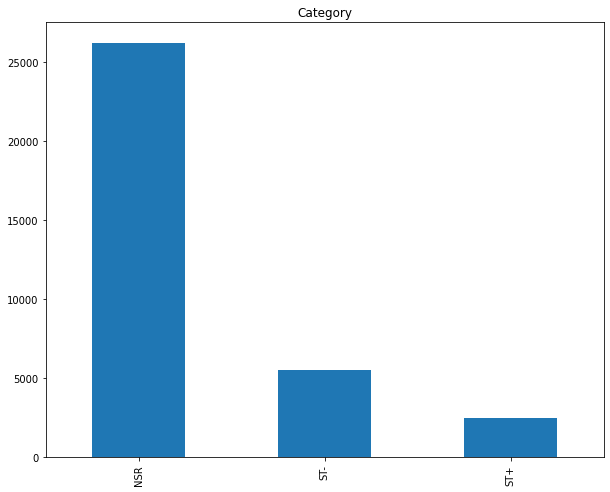

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.219210,0.101301,0.071494,0.053500,0.102907,-0.028753,0.044410,-0.002493,0.004377,...,-0.077538,-0.054871,-0.040977,-0.037365,-0.023672,-0.057237,-0.042960,-0.052143,-0.079161,-0.066310
dw_2,0.219210,1.000000,0.838628,0.486610,0.180151,0.408486,-0.502032,-0.337710,0.001285,0.018225,...,-0.123426,0.167397,0.237288,0.168364,0.049215,0.034692,0.128171,0.009246,-0.115564,-0.075292
dw_3,0.101301,0.838628,1.000000,0.680243,0.272747,0.255846,-0.548064,-0.460442,0.004292,0.010350,...,-0.203574,0.143928,0.272752,0.119350,-0.051559,0.061458,0.046053,-0.019790,-0.131894,-0.046861
dw_4,0.071494,0.486610,0.680243,1.000000,0.880644,-0.012857,-0.262781,-0.246875,0.003327,0.003775,...,-0.154983,0.064231,0.121135,0.050684,-0.040099,0.050791,0.024330,-0.029443,-0.102508,-0.042964
dw_5,0.053500,0.180151,0.272747,0.880644,1.000000,-0.126287,-0.018966,-0.039939,0.000859,0.000096,...,-0.070726,0.009459,0.007874,0.021196,0.000299,0.019165,0.013247,-0.034829,-0.053621,-0.029838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.057237,0.034692,0.061458,0.050791,0.019165,-0.138724,0.094631,0.121316,-0.001690,0.004790,...,-0.134379,-0.207376,-0.072612,0.035689,0.062709,1.000000,0.019376,0.001574,-0.345510,-0.225272
cfr_13,-0.042960,0.128171,0.046053,0.024330,0.013247,0.077703,-0.006064,0.009997,0.003478,-0.000130,...,0.147883,0.041925,-0.211124,-0.268978,-0.011602,0.019376,1.000000,0.223072,0.131959,-0.159064
cfr_14,-0.052143,0.009246,-0.019790,-0.029443,-0.034829,0.004839,0.022487,0.027808,0.003788,-0.003911,...,0.109109,0.222240,0.044405,-0.175685,-0.289441,0.001574,0.223072,1.000000,0.198522,-0.135727
cfr_15,-0.079161,-0.115564,-0.131894,-0.102508,-0.053621,0.045425,0.082850,0.052462,0.001549,-0.008696,...,0.279721,0.160473,-0.089826,-0.144377,-0.074435,-0.345510,0.131959,0.198522,1.000000,0.297959


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'mfw_6', 'fft_161', 'fft_252', 'fft_183', 'fft_220', 'fft_229', 'fft_186', 'fft_240', 'fft_199', 'fft_196', 'fft_138', 'fft_136', 'fft_162', 'fft_154', 'fft_132', 'fft_231', 'fft_221', 'mfw_10', 'fft_134', 'fft_210', 'fft_214', 'fft_225', 'fft_245', 'fft_198', 'fft_190', 'fft_151', 'fft_202', 'fft_216', 'mfw_13', 'fft_239', 'fft_233', 'fft_160', 'fft_200', 'fft_227', 'fft_140', 'fft_194', 'fft_197', 'fft_147', 'fft_175', 'fft_223', 'fft_133', 'fft_149', 'fft_243', 'fft_232', 'fft_145', 'fft_254', 'fft_201', 'fft_185', 'fft_193', 'fft_250', 'fft_139', 'fft_238', 'fft_163', 'fft_164', 'fft_191', 'fft_207', 'mfw_11', 'fft_148', 'fft_174', 'fft_209', 'fft_159', 'fft_157', 'fft_168', 'fft_222', 'fft_171', 'fft_180', 'fft_219', 'fft_144', 'fft_181', 'fft_224', 'fft_237', 'fft_192', 'fft_226', 'fft_228', 'fft_135', 'fft_177', 'fft_246', 'fft_241', 'fft_188', 'fft_166', 'fft_158', 'fft_130', 'fft_173', 'fft_203', 'fft_167', 'mfw_15', 'cfr_16', 'fft_146', 'fft_218', 'fft_165', 'fft_155', 'fft_

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 78


### Visualization best features

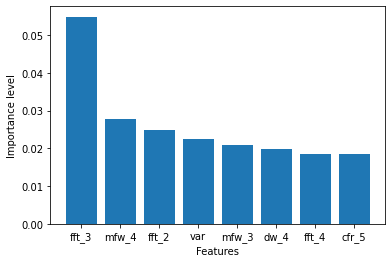

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,65.861928,67.716291,67.206386,18.973287,2.756737,0.736288,-0.634501,-1.015121,-0.279539,0.905306,...,0.020720,0.039231,-0.038497,0.024202,-0.033980,0.046029,-0.071080,0.009209,-0.027384,-0.007471
1,67.175188,66.539171,66.278974,18.879508,2.752145,0.710574,-0.608829,-1.008338,-0.375129,-0.354970,...,0.009445,0.040896,-0.045707,0.028543,-0.033995,0.039226,-0.065687,-0.004942,-0.011601,-0.016082
2,67.331260,67.526064,67.904703,19.526248,2.883850,0.724048,-0.611290,-1.007119,-0.471325,1.782405,...,0.011313,0.048344,-0.064803,0.051981,-0.056875,0.061396,-0.081542,0.009957,-0.023760,-0.019310
3,66.507411,69.358972,68.845433,19.399284,2.811633,0.728870,-0.631538,-1.076715,-0.451683,-3.475203,...,0.013055,0.040612,-0.042918,0.033450,-0.043966,0.053377,-0.073200,0.002332,-0.021755,-0.003223
4,71.500586,69.600473,69.015425,19.518971,2.844739,0.706509,-0.610843,-1.008555,-0.438800,-1.080058,...,0.004456,0.042616,-0.047597,0.025825,-0.031552,0.048798,-0.093202,0.026254,-0.038423,-0.005951


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 7.999271631240845 s
Tot: Accuracy 0.8181818181818182 Precision 0.8512396694214877 Recall 0.8181818181818182 Specificity 0.18181818181818182 F1 0.7363636363636364
NSR: Accuracy 0.8181818181818182 Precision 0.8181818181818182 Recall 1.0 Specificity 0.0 F1 0.9
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 8.098462343215942 s
Tot: Accuracy 0.801354401805869 Precision 0.8408144754877731 Recall 0.801354401805869 Specificity 0.1986455981941309 F1 0.7129844928347958
NSR: Accuracy 0.801354401805869 Precision 0.801354401805869 Recall 1.0 Specificity 0.0 F1 0.8897243107769424
ST+: Accuracy 0.801354401805869 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.801354401805869 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 7.684062957763672 s
Tot: Accuracy 0.9197183098591549 Precision 0.9261634596310255 Recall 0.9197183098591549 Specificity 0.08028169014084507 F1 0.8812561354923377
NSR: Accuracy 0.9197183098591549 Precision 0.9197183098591549 Recall 1.0 Specificity 0.0 F1 0.9581804842259721
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 7.670142412185669 s
Tot: Accuracy 0.865546218487395 Precision 0.8836240378504344 Recall 0.865546218487395 Specificity 0.13445378151260504 F1 0.803164509046862
NSR: Accuracy 0.865546218487395 Precision 0.865546218487395 Recall 1.0 Specificity 0.0 F1 0.927927927927928
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 7.841295480728149 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 7.897511005401611 s
Tot: Accuracy 0.9958333333333333 Precision 1.0 Recall 0.9958333333333333 Specificity 0.0 F1 0.9979123173277661
NSR: Accuracy 0.9958333333333333 Precision 1.0 Recall 0.9958333333333333 Specificity 0.0 F1 0.9979123173277662
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9958333333333333 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 8.027191162109375 s
Tot: Accuracy 0.7113237639553429 Precision 0.7946577332122534 Recall 0.7113237639553429 Specificity 0.2886762360446571 F1 0.5913334552173027
NSR: Accuracy 0.7113237639553429 Precision 0.7113237639553429 Recall 1.0 Specificity 0.0 F1 0.8313140726933831
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 8.014036178588867 s
Tot: Accuracy 0.7574334898278561 Precision 0.7531845663352094 Recall 0.7574334898278561 Specificity 0.33229115929718533 F1 0.6815949945840399
NSR: Accuracy 0.7574334898278561 Precision 0.7581168831168831 Recall 0.9873150105708245 Specificity 0.10240963855421686 F1 0.8576675849403121
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.7391304347826086 Recall 0.10240963855421686 Specificity 0.9873150105708245 F1 0.1798941798941799
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 7.3772828578948975 s
Tot: Accuracy 0.8922651933701657 Precision 0.9789362299840809 Recall 0.8922651933701657 Specificity 0.34036883926386685 F1 0.9319830944318558
NSR: Accuracy 0.8922651933701657 Precision 0.9907550077041603 Recall 0.8993006993006993 Specificity 0.3333333333333333 F1 0.9428152492668622
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.04 Recall 0.3333333333333333 Specificity 0.8993006993006993 F1 0.07142857142857142
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 7.0831139087677 s
Tot: Accuracy 0.6511936339522546 Precision 0.7728595149476885 Recall 0.6511936339522546 Specificity 0.34880636604774534 F1 0.513632247824188
NSR: Accuracy 0.6511936339522546 Precision 0.6511936339522546 Recall 1.0 Specificity 0.0 F1 0.7887550200803213
ST+: Accuracy 0.6511936339522546 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6511936339522546 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 7.538060188293457 s
Tot: Accuracy 0.7732558139534884 Precision 0.7361847334047479 Recall 0.7732558139534884 Specificity 0.2720058046219655 F1 0.6930126479924531
NSR: Accuracy 0.7732558139534884 Precision 0.7771173848439822 Recall 0.9886578449905482 Specificity 0.05660377358490566 F1 0.870216306156406
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6 Recall 0.05660377358490566 Specificity 0.9886578449905482 F1 0.10344827586206896
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 7.543463945388794 s
Tot: Accuracy 0.7549668874172185 Precision 0.8150081136792245 Recall 0.7549668874172185 Specificity 0.24503311258278146 F1 0.649556416343871
NSR: Accuracy 0.7549668874172185 Precision 0.7549668874172185 Recall 1.0 Specificity 0.0 F1 0.8603773584905661
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 7.906249761581421 s
Tot: Accuracy 0.9056261343012704 Precision 0.9145325608281922 Recall 0.9056261343012704 Specificity 0.09437386569872959 F1 0.8607760781263504
NSR: Accuracy 0.9056261343012704 Precision 0.9056261343012704 Recall 1.0 Specificity 0.0 F1 0.9504761904761905
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 7.887190341949463 s
Tot: Accuracy 0.8090909090909091 Precision 0.8455371900826446 Recall 0.8090909090909091 Specificity 0.19090909090909092 F1 0.723709456372773
NSR: Accuracy 0.8090909090909091 Precision 0.8090909090909091 Recall 1.0 Specificity 0.0 F1 0.8944723618090452
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 7.719230651855469 s
Tot: Accuracy 0.813953488372093 Precision 0.6703655191162297 Recall 0.813953488372093 Specificity 0.17959489872468118 F1 0.7352143980050956
NSR: Accuracy 0.813953488372093 Precision 0.8182784272051009 Recall 0.9935483870967742 Specificity 0.0 F1 0.8974358974358974
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9935483870967742 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 7.861800193786621 s
Tot: Accuracy 0.9488304093567251 Precision 0.9514487363633254 Recall 0.9488304093567251 Specificity 0.05116959064327485 F1 0.9239173828544857
NSR: Accuracy 0.9488304093567251 Precision 0.9488304093567251 Recall 1.0 Specificity 0.0 F1 0.9737434358589648
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 7.821764707565308 s
Tot: Accuracy 0.7230113636363636 Precision 0.7492416043552407 Recall 0.7230113636363636 Specificity 0.317559028064161 F1 0.620957534863039
NSR: Accuracy 0.7230113636363636 Precision 0.7215007215007215 Recall 0.9960159362549801 Specificity 0.04455445544554455 F1 0.8368200836820083
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8181818181818182 Recall 0.04455445544554455 Specificity 0.9960159362549801 F1 0.08450704225352113
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 7.658688068389893 s
Tot: Accuracy 0.9700690713737529 Precision 0.9709649318621824 Recall 0.9700690713737529 Specificity 0.029930928626247123 F1 0.9553309748472331
NSR: Accuracy 0.9700690713737529 Precision 0.9700690713737529 Recall 1.0 Specificity 0.0 F1 0.9848071679002728
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 7.686031341552734 s
Tot: Accuracy 0.8586762075134168 Precision 0.8786486218362076 Recall 0.8586762075134168 Specificity 0.1413237924865832 F1 0.7933870637275074
NSR: Accuracy 0.8586762075134168 Precision 0.8586762075134168 Recall 1.0 Specificity 0.0 F1 0.9239653512993263
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 7.727554082870483 s
Tot: Accuracy 0.9875954198473282 Precision 0.9790979449155635 Recall 0.9875954198473282 Specificity 0.010475939844089307 F1 0.983328324898396
NSR: Accuracy 0.9875954198473282 Precision 0.9894837476099426 Recall 0.9980713596914176 Specificity 0.0 F1 0.9937590014402304
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9980713596914176 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 8.018364191055298 s
Tot: Accuracy 0.8134453781512605 Precision 0.8482480050843867 Recall 0.8134453781512605 Specificity 0.1865546218487395 F1 0.7297637868863949
NSR: Accuracy 0.8134453781512605 Precision 0.8134453781512605 Recall 1.0 Specificity 0.0 F1 0.897126969416126
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 7.942397594451904 s
Tot: Accuracy 0.6733466933867736 Precision 0.7800490761081281 Recall 0.6733466933867736 Specificity 0.32665330661322645 F1 0.5419029676118705
NSR: Accuracy 0.6733466933867736 Precision 0.6733466933867736 Recall 1.0 Specificity 0.0 F1 0.8047904191616767
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 7.734591007232666 s
Tot: Accuracy 0.34476843910806176 Precision 0.6006192673479412 Recall 0.34476843910806176 Specificity 0.6628906391523469 F1 0.20227885959001488
NSR: Accuracy 0.34476843910806176 Precision 0.3345070422535211 Recall 0.979381443298969 Specificity 0.028277634961439587 F1 0.49868766404199477
ST+: Accuracy 0.34476843910806176 Precision 0.7333333333333333 Recall 0.028277634961439587 Specificity 0.979381443298969 F1 0.054455445544554455
ST-: Accuracy 0.34476843910806176 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#
#---------------------#
24 of 56 - 7.056188344955444 s
Tot: Accuracy 0.8447488584474886 Precision 0.8688517754008466 Recall 0.8447488584474886 Specificity 0.1552511415525114 F1 0.7736561327365613
NSR: Accuracy 0.8447488584474886 Precision 0.8447488584474886 Recall 1.0 Specificity 0.0 F1 0.9158415841584158
ST+: Accuracy 0.908675799086758 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.908

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 6.571845531463623 s
Tot: Accuracy 0.68 Precision 0.7828407460545194 Recall 0.68 Specificity 0.333215859030837 F1 0.5548063916759569
NSR: Accuracy 0.68 Precision 0.6786226685796269 Recall 1.0 Specificity 0.013215859030837005 F1 0.8085470085470085
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.013215859030837005 Specificity 1.0 F1 0.02608695652173913
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 6.854053497314453 s
Tot: Accuracy 0.7296819787985865 Precision 0.8036958374057088 Recall 0.7296819787985865 Specificity 0.2667844522968198 F1 0.6186272138946137
NSR: Accuracy 0.7296819787985865 Precision 0.7322695035460993 Recall 0.9951807228915662 Specificity 0.0 F1 0.8437180796731358
ST+: Accuracy 0.9964664310954063 Precision 0.0 Recall 1.0 Specificity 0.9964664310954063 F1 0.0
ST-: Accuracy 0.9964664310954063 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 6.654847860336304 s
Tot: Accuracy 0.6701940035273368 Precision 0.8152636413505978 Recall 0.6701940035273368 Specificity 0.23809523809523808 F1 0.7319167488700778
NSR: Accuracy 0.6701940035273368 Precision 0.893719806763285 Recall 0.7212475633528265 Specificity 0.18518518518518517 F1 0.7982740021574972
ST+: Accuracy 0.982363315696649 Precision 0.0 Recall 1.0 Specificity 0.982363315696649 F1 0.0
ST-: Accuracy 0.982363315696649 precision 0.06993006993006994 Recall 0.18518518518518517 Specificity 0.7407407407407407 F1 0.10152284263959391
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 6.782768726348877 s
Tot: Accuracy 0.05831265508684864 Precision 0.953977686150861 Recall 0.05831265508684864 Specificity 0.9521175926315346 F1 0.02415539368713146
NSR: Accuracy 0.05831265508684864 Precision 0.04887218045112782 Recall 1.0 Specificity 0.010430247718383311 F1 0.09318996415770608
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.010430247718383311 Specificity 1.0 F1 0.02064516129032258
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 6.844288349151611 s
Tot: Accuracy 0.14345991561181434 Precision 0.8771208317755346 Recall 0.14345991561181434 Specificity 0.8565400843881856 F1 0.03599732199853644
NSR: Accuracy 0.14345991561181434 Precision 0.14345991561181434 Recall 1.0 Specificity 0.0 F1 0.25092250922509224
ST+: Accuracy 0.14345991561181434 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14345991561181434 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 6.47028923034668 s
Tot: Accuracy 0.9185303514376997 Precision 0.9288611736470442 Recall 0.9185303514376997 Specificity 0.07667731629392971 F1 0.884114143432124
NSR: Accuracy 0.9185303514376997 Precision 0.9229534510433387 Recall 0.9948096885813149 Specificity 0.0 F1 0.9575353871773523
ST+: Accuracy 0.9952076677316294 Precision 0.0 Recall 1.0 Specificity 0.9952076677316294 F1 0.0
ST-: Accuracy 0.9952076677316294 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 6.6206700801849365 s
Tot: Accuracy 0.9044834307992202 Precision 0.8841021869526193 Recall 0.9044834307992202 Specificity 0.3045403591925763 F1 0.884547818891685
NSR: Accuracy 0.9044834307992202 Precision 0.9168356997971603 Recall 0.9826086956521739 Specificity 0.22641509433962265 F1 0.9485834207764953
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6 Recall 0.22641509433962265 Specificity 0.9826086956521739 F1 0.3287671232876712
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 6.713437557220459 s
Tot: Accuracy 0.4904891304347826 Precision 0.7525831991411702 Recall 0.4904891304347826 Specificity 0.5278354768950603 F1 0.3331139873561357
NSR: Accuracy 0.4904891304347826 Precision 0.48559670781893005 Recall 1.0 Specificity 0.01832460732984293 F1 0.6537396121883656
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.01832460732984293 Specificity 1.0 F1 0.03598971722365039
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 6.665589332580566 s
Tot: Accuracy 0.8494809688581315 Precision 0.8721369475940183 Recall 0.8494809688581315 Specificity 0.15051903114186851 F1 0.7803464091849254
NSR: Accuracy 0.8494809688581315 Precision 0.8494809688581315 Recall 1.0 Specificity 0.0 F1 0.9186155285313378
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 6.572821140289307 s
Tot: Accuracy 0.6103542234332425 Precision 0.9342684433396232 Recall 0.6103542234332425 Specificity 0.8952337260322578 F1 0.7056620016860388
NSR: Accuracy 0.6103542234332425 Precision 0.9901960784313726 Recall 0.5889212827988338 Specificity 0.9166666666666666 F1 0.7385740402193784
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.13496932515337423 Recall 0.9166666666666666 Specificity 0.5889212827988338 F1 0.23529411764705882
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 6.702696084976196 s
Tot: Accuracy 0.935672514619883 Precision 0.9495484272812208 Recall 0.935672514619883 Specificity 0.05263157894736842 F1 0.9158848783590395
NSR: Accuracy 0.935672514619883 Precision 0.9467455621301775 Recall 0.9876543209876543 Specificity 0.0 F1 0.9667673716012084
ST+: Accuracy 0.9883040935672515 Precision 0.0 Recall 1.0 Specificity 0.9883040935672515 F1 0.0
ST-: Accuracy 0.9883040935672515 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 6.640201091766357 s
Tot: Accuracy 0.9642857142857143 Precision 1.0 Recall 0.9642857142857143 Specificity 0.0 F1 0.9818181818181819
NSR: Accuracy 0.9642857142857143 Precision 1.0 Recall 0.9642857142857143 Specificity 0.0 F1 0.9818181818181818
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9642857142857143 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 6.665589094161987 s
Tot: Accuracy 0.8561253561253561 Precision 0.8467918479024541 Recall 0.8561253561253561 Specificity 0.3156296914258698 F1 0.85117759622147
NSR: Accuracy 0.8561253561253561 Precision 0.9123630672926447 Recall 0.928343949044586 Specificity 0.24324324324324326 F1 0.9202841357537489
ST+: Accuracy 0.9985754985754985 Precision 0.0 Recall 1.0 Specificity 0.9985754985754985 F1 0.0
ST-: Accuracy 0.9985754985754985 precision 0.2903225806451613 Recall 0.24324324324324326 Specificity 0.9299363057324841 F1 0.2647058823529412
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 6.711484670639038 s
Tot: Accuracy 0.046 Precision 0.9561202404809619 Recall 0.046 Specificity 0.9540964360587002 F1 0.004053639846743295
NSR: Accuracy 0.048 Precision 0.04609218436873747 Recall 1.0 Specificity 0.0020964360587002098 F1 0.08812260536398467
ST+: Accuracy 0.046 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.046 precision 0.0 Recall 1.0 Specificity 0.998 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 6.6519176959991455 s
Tot: Accuracy 0.76775956284153 Precision 0.7410872316368942 Recall 0.76775956284153 Specificity 0.28432558719694134 F1 0.6866260374780905
NSR: Accuracy 0.76775956284153 Precision 0.7706293706293706 Recall 0.9892280071813285 Specificity 0.06285714285714286 F1 0.8663522012578616
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6470588235294118 Recall 0.06285714285714286 Specificity 0.9892280071813285 F1 0.11458333333333334
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 6.639223575592041 s
Tot: Accuracy 0.840983606557377 Precision 0.8580843804610137 Recall 0.840983606557377 Specificity 0.3148950012524701 F1 0.7911407759146307
NSR: Accuracy 0.840983606557377 Precision 0.8375634517766497 Recall 0.9979838709677419 Specificity 0.15789473684210525 F1 0.9107635694572216
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9473684210526315 Recall 0.15789473684210525 Specificity 0.9979838709677419 F1 0.2706766917293233
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 6.622622966766357 s
Tot: Accuracy 0.36363636363636365 Precision 0.7692199775533108 Recall 0.36363636363636365 Specificity 0.6387790953008344 F1 0.19580911931469316
NSR: Accuracy 0.36363636363636365 Precision 0.3626543209876543 Recall 1.0 Specificity 0.0024154589371980675 F1 0.5322763306908268
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0024154589371980675 Specificity 1.0 F1 0.0048192771084337345
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 6.717343807220459 s
Tot: Accuracy 0.9203389830508475 Precision 0.9314759525770515 Recall 0.9203389830508475 Specificity 0.513123050411186 F1 0.9253493969388747
NSR: Accuracy 0.9203389830508475 Precision 0.9669117647058824 Recall 0.9477477477477477 Specificity 0.4857142857142857 F1 0.9572338489535941
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.3695652173913043 Recall 0.4857142857142857 Specificity 0.9477477477477477 F1 0.4197530864197531
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 6.5503623485565186 s
Tot: Accuracy 0.8571428571428571 Precision 0.8775510204081632 Recall 0.8571428571428571 Specificity 0.14285714285714285 F1 0.7912087912087911
NSR: Accuracy 0.8571428571428571 Precision 0.8571428571428571 Recall 1.0 Specificity 0.0 F1 0.923076923076923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 6.598209857940674 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 6.912910461425781 s
Tot: Accuracy 0.6072234762979684 Precision 0.7622340945201747 Recall 0.6072234762979684 Specificity 0.38959513154594533 F1 0.46459855289183527
NSR: Accuracy 0.6094808126410836 Precision 0.6127562642369021 Recall 0.9889705882352942 Specificity 0.005847953216374269 F1 0.7566807313642758
ST+: Accuracy 0.6139954853273137 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6139954853273137 precision 0.0 Recall 1.0 Specificity 0.9909706546275395 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 6.646066665649414 s
Tot: Accuracy 0.7579365079365079 Precision 0.8166477326517089 Recall 0.7579365079365079 Specificity 0.2501935733643051 F1 0.6555575559058532
NSR: Accuracy 0.7579365079365079 Precision 0.757455268389662 Recall 1.0 Specificity 0.008130081300813009 F1 0.8619909502262444
ST+: Accuracy 0.9801587301587301 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9801587301587301 precision 1.0 Recall 

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 6.612858772277832 s
Tot: Accuracy 0.4341736694677871 Precision 0.5362578998689594 Recall 0.4341736694677871 Specificity 0.5758567070458733 F1 0.34533985715015525
NSR: Accuracy 0.43557422969187676 Precision 0.416403785488959 Recall 0.8888888888888888 Specificity 0.11270983213429256 F1 0.5671321160042964
ST+: Accuracy 0.9915966386554622 Precision 0.0 Recall 1.0 Specificity 0.9915966386554622 F1 0.0
ST-: Accuracy 0.9915966386554622 precision 0.6216216216216216 Recall 0.11031175059952038 Specificity 0.9057239057239057 F1 0.18737270875763748
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 7.3598809242248535 s
Tot: Accuracy 0.9846491228070176 Precision 0.9830237928893029 Recall 0.9846491228070176 Specificity 0.20869899249231727 F1 0.9838047962282968
NSR: Accuracy 0.9846491228070176 Precision 0.9911504424778761 Recall 0.9933481152993349 Specificity 0.2 F1 0.9922480620155039
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.25 Recall 0.2 Specificity 0.9933481152993349 F1 0.22222222222222224
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 7.22903037071228 s
Tot: Accuracy 0.996742671009772 Precision 1.0 Recall 0.996742671009772 Specificity 0.0 F1 0.9983686786296901
NSR: Accuracy 0.996742671009772 Precision 1.0 Recall 0.996742671009772 Specificity 0.0 F1 0.99836867862969
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.996742671009772 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 7.475106477737427 s
Tot: Accuracy 0.9933884297520661 Precision 1.0 Recall 0.9933884297520661 Specificity 0.0 F1 0.9966832504145937
NSR: Accuracy 0.9933884297520661 Precision 1.0 Recall 0.9933884297520661 Specificity 0.0 F1 0.9966832504145937
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9933884297520661 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 7.8539910316467285 s
Tot: Accuracy 0.11988716502115655 Precision 0.8935801700258682 Recall 0.11988716502115655 Specificity 0.8816228857591117 F1 0.026470593560512103
NSR: Accuracy 0.14104372355430184 Precision 0.12265512265512266 Recall 0.9883720930232558 Specificity 0.024077046548956663 F1 0.21822849807445444
ST+: Accuracy 0.12129760225669958 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12129760225669958 precision 0.0 Recall 1.0 Specificity 0.9774330042313117 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 8.239707231521606 s
Tot: Accuracy 0.9613821138211383 Precision 1.0 Recall 0.9613821138211383 Specificity 0.0 F1 0.9803108808290155
NSR: Accuracy 0.9613821138211383 Precision 1.0 Recall 0.9613821138211383 Specificity 0.0 F1 0.9803108808290155
ST+: Accuracy 0.9634146341463414 Precision 0.0 Recall 1.0 Specificity 0.9634146341463414 F1 0.0
ST-: Accuracy 0.9634146341463414 precision 0.0 Recall 1.0 Specificity 0.9979674796747967 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 8.173304557800293 s
Tot: Accuracy 0.7851622874806801 Precision 0.8147497922378508 Recall 0.7851622874806801 Specificity 0.46039766794103526 F1 0.7374829841064479
NSR: Accuracy 0.7851622874806801 Precision 0.7738693467336684 Recall 0.9914163090128756 Specificity 0.2541436464088398 F1 0.8692380056444027
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.92 Recall 0.2541436464088398 Specificity 0.9914163090128756 F1 0.3982683982683983
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 8.758227348327637 s
Tot: Accuracy 0.8724954462659381 Precision 0.8675911669299949 Recall 0.8724954462659381 Specificity 0.19296685814373477 F1 0.8225645127236161
NSR: Accuracy 0.8724954462659381 Precision 0.8729281767955801 Recall 0.9978947368421053 Specificity 0.06756756756756757 F1 0.931237721021611
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8333333333333334 Recall 0.06756756756756757 Specificity 0.9978947368421053 F1 0.12500000000000003
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 8.730887651443481 s
Tot: Accuracy 0.9053030303030303 Precision 0.9142705463728191 Recall 0.9053030303030303 Specificity 0.0946969696969697 F1 0.8603078498704742
NSR: Accuracy 0.9053030303030303 Precision 0.9053030303030303 Recall 1.0 Specificity 0.0 F1 0.9502982107355865
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 8.862712383270264 s
Tot: Accuracy 0.7751004016064257 Precision 0.8256802309640167 Recall 0.7751004016064257 Specificity 0.2248995983935743 F1 0.6768976357920369
NSR: Accuracy 0.7751004016064257 Precision 0.7751004016064257 Recall 1.0 Specificity 0.0 F1 0.8733031674208145
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.818182,0.851240,0.818182,0.181818,0.736364,0.818182,0.818182,1.000000,0.000000,0.900000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,0.000000,1.000000,0.000000
1,0.801354,0.840814,0.801354,0.198646,0.712984,0.801354,0.801354,1.000000,0.000000,0.889724,0.801354,1.0,0.0,1.0,0.0,0.801354,1.00000,1.000000,1.000000,1.000000
2,0.919718,0.926163,0.919718,0.080282,0.881256,0.919718,0.919718,1.000000,0.000000,0.958180,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,0.000000,1.000000,0.000000
3,0.865546,0.883624,0.865546,0.134454,0.803165,0.865546,0.865546,1.000000,0.000000,0.927928,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.000000
5,0.995833,1.000000,0.995833,0.000000,0.997912,0.995833,1.000000,0.995833,0.000000,0.997912,1.000000,1.0,1.0,1.0,1.0,1.000000,0.00000,1.000000,0.995833,0.000000
6,0.711324,0.794658,0.711324,0.288676,0.591333,0.711324,0.711324,1.000000,0.000000,0.831314,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,0.000000,1.000000,0.000000
7,0.757433,0.753185,0.757433,0.332291,0.681595,0.757433,0.758117,0.987315,0.102410,0.857668,1.000000,1.0,1.0,1.0,1.0,1.000000,0.73913,0.102410,0.987315,0.179894
8,0.892265,0.978936,0.892265,0.340369,0.931983,0.892265,0.990755,0.899301,0.333333,0.942815,1.000000,1.0,1.0,1.0,1.0,1.000000,0.04000,0.333333,0.899301,0.071429
9,0.651194,0.772860,0.651194,0.348806,0.513632,0.651194,0.651194,1.000000,0.000000,0.788755,0.651194,1.0,0.0,1.0,0.0,0.651194,1.00000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_16beats_l1so.csv')

######## Total ########
Accuracy 0.7577609138347575
Precision 0.8635543386683622
Recall 0.7577609138347575
Specificity 0.28331951281284523
F1 0.7014599982831982
######## NSR ########
Accuracy 0.7582397433901208
Precision 0.7736715947881615
Recall 0.9774382057841743
Specificity 0.06360917726749102
F1 0.8312666384209646
######## ST+ ########
Accuracy 0.9201220051209954
Precision 0.8702380952380953
Recall 0.8397906720528828
Specificity 0.9981305307637002
F1 0.7152581329561528
######## ST- ########
Accuracy 0.9201220051209954
Precision 0.6943121722432382
Recall 0.31250243305143866
Specificity 0.9793407186164116
F1 0.164509454426599
